# EDA and Feature engineering


## Intro and Goals

### Analysing the booking completetion of booking tickets
#### Problem statement and Scope
Airline and travel booking platforms often experience a significant number of incomplete bookings — customers start the booking process (selecting routes, seats, and preferences) but abandon before final payment.
This project aims to predict whether a booking will be completed using historical booking data containing features like purchase lead time, travel routes, flight durations, and seat preferences.

By identifying factors that influence booking completion, the business can:

Optimize the booking process to reduce drop-offs.

Target at-risk customers with personalized reminders or offers.

Improve marketing ROI by focusing on high-likelihood customers.

Goal: Build a machine learning model that predicts booking completion with high accuracy, while ensuring interpretability for business stakeholders.

Success Criteria:

Primary: Achieve at least 85% accuracy or 0.85 F1-score on test data.

Secondary: Identify the top 5 most influential factors affecting booking completion.


## Load and data checks

In [2]:
#imports

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import plotly.express as px

In [3]:
df=pd.read_csv("customer_booking.csv",encoding="ISO-8859-1")
df=df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

In [4]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,1.000000,1.000000,1.000000,9.500000,1.000000


## Target Balance

In [5]:
import pandas as pd


if df['booking_complete'].dtype != 'int64' and df['booking_complete'].dtype != 'float64':
    
    df['booking_complete'] = df['booking_complete'].map({True:1, False:0, 'Yes':1, 'No':0, 'Y':1, 'N':0}).fillna(df['booking_complete'])
df['booking_complete'] = df['booking_complete'].astype(int)

# Class balance
counts = df['booking_complete'].value_counts(dropna=False)
rates = df['booking_complete'].value_counts(normalize=True, dropna=False).mul(100).round(2)

print("Booking completion class counts:")
print(counts.to_string())
print("\nBooking completion class rates (%):")
print(rates.to_string())

# Small, neat display as a DataFrame
class_balance = pd.DataFrame({
    'count': counts,
    'rate_%': rates
}).sort_index()
display(class_balance)


Booking completion class counts:
booking_complete
0    42522
1     7478

Booking completion class rates (%):
booking_complete
0    85.04
1    14.96


,count,rate_%
booking_complete,,
0,42522,85.04
1,7478,14.96


## Type cleaning

In [6]:
# map the days with their corresponding order in a week 
df['flight_day'].value_counts()
mapping={'Mon':1,'Tue':2,'Wed':3,'Thu':4,'Fri':5,'Sat':6,'Sun':7}
df['flight_day_numerical']=df['flight_day'].map(mapping)
df['flight_day_numerical']

0        6
1        6
2        3
3        6
4        3
        ..
49995    6
49996    7
49997    6
49998    1
49999    4
Name: flight_day_numerical, Length: 50000, dtype: int64

In [7]:
df['flight_duration']=df['flight_duration'].clip(lower=0)
df['flight_hour']=df['flight_hour'].clip(lower=0)
df['num_passengers']=df['num_passengers'].clip(lower=1)
df['length_of_stay']=df['length_of_stay'].clip(lower=0)
df['purchase_lead']=df['purchase_lead'].clip(lower=0)

In [8]:
num_cols = df.select_dtypes(include=['number']).columns.tolist()
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()

df[num_cols] = df[num_cols].apply(lambda s: s.fillna(s.median()))
df[cat_cols] = df[cat_cols].apply(lambda s: s.fillna('Unknown'))

In [9]:
display(df.isna().sum().sort_values(ascending=False).head(15))

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
flight_day_numerical     0
dtype: int64

## Bins and dayparts

In [10]:


# Lead bins
lead_bins=[-np.inf,3,7,14,30,90,np.inf]
lead_bins_label=['0-3','4-7','8-14','15-30','31-90','90+']
df['lead_bins']=pd.cut(df['purchase_lead'].clip(lower=0),bins=lead_bins,labels=lead_bins_label,include_lowest=True)
# length of stay bins
stay_bins=[-np.inf,3,7,14,30,90,np.inf]
stay_bins_label=['0-3','4-7','8-14','15-30','31-90','90+']
df['stay_bin']=pd.cut(df['length_of_stay'].clip(lower=0),bins=stay_bins,labels=stay_bins_label,include_lowest=True)
#part of the day
def day_part(h):
    if 0 <= h <= 5: return 'night'
    if 6 <= h <= 11: return 'morning'
    if 12 <= h <= 17: return 'afternoon'
    return 'evening'
df['daypart'] = df['flight_hour'].apply(day_part)





## Completion rate plots

In [11]:


col = df.columns.to_list()
complete = df[df['booking_complete'] == 1]
not_complete = df[df['booking_complete'] == 0]

def complete_rate(c: str) -> pd.DataFrame:
    
    cc = complete[c].value_counts(normalize=True, dropna=False).mul(100).round(2)
    nc = not_complete[c].value_counts(normalize=True, dropna=False).mul(100).round(2)

    idx = cc.index.union(nc.index)
    cc = cc.reindex(idx, fill_value=0.0)
    nc = nc.reindex(idx, fill_value=0.0)


    out = pd.DataFrame({
        'feature': c,
        'value': idx,
        'complete_%': cc.values,
        'not_complete_%': nc.values
    })
    return out

# Aggregate for all columns except the target
results = []
for c in col:
    if c == 'booking_complete':
        continue
    results.append(complete_rate(c))

summary = pd.concat(results, ignore_index=True)
display(summary)



,feature,value,complete_%,not_complete_%
0,num_passengers,1,59.57,63.25
1,num_passengers,2,27.43,25.29
2,num_passengers,3,6.57,5.76
3,num_passengers,4,3.68,3.55
4,num_passengers,5,1.46,1.06
...,...,...,...,...
1798,stay_bin,8-14,0.00,0.00
1799,daypart,afternoon,30.65,26.94
1800,daypart,evening,4.69,6.15
1801,daypart,morning,36.44,37.49


In [12]:


fig = px.bar(summary, x='feature', y='complete_%')
fig.show()
fig2=px.bar(summary,x='feature',y='not_complete_%')
fig2.show()

## Numeric vs Target plot

In [22]:
target=df['booking_complete']
numeric_cols=['purchase_lead', 'length_of_stay', 'flight_duration', 'flight_hour','num_pasengers',]


for c in numeric_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

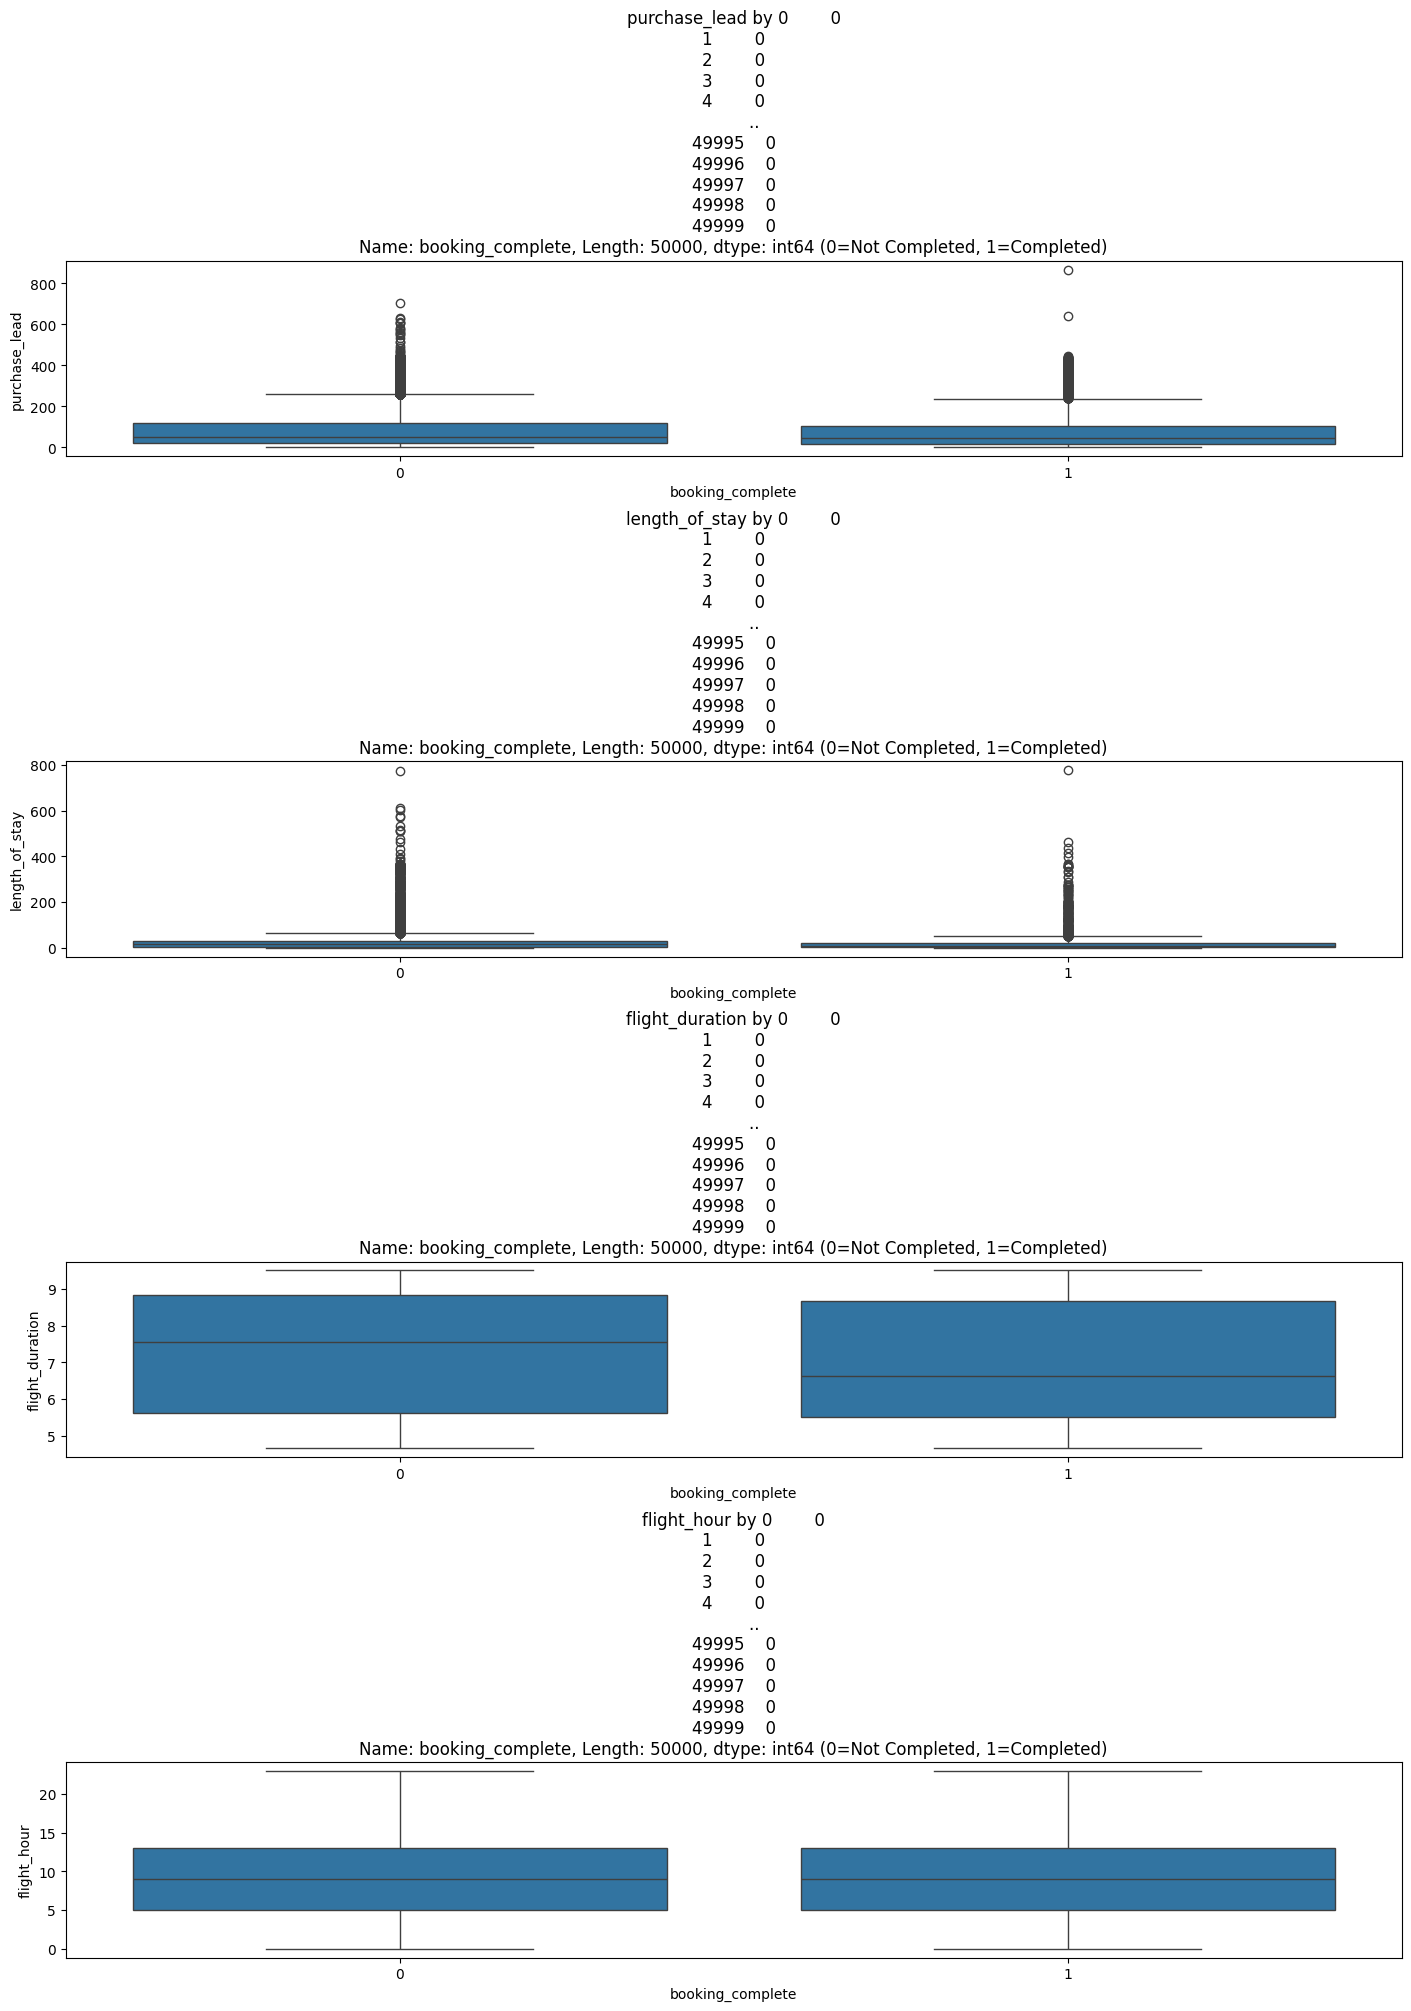

Columns being plotted: ['purchase_lead', 'length_of_stay', 'flight_duration', 'flight_hour']


In [18]:
cols_target=[c for c in numeric_cols if c in df.columns]
n=len(cols_target)
fig,axes=plt.subplots(nrows=n,ncols=1,figsize=(14,5*n),constrained_layout=True)
if n == 1:
    axes = [axes] 
for ax, col in zip(axes, cols_target):
    sns.boxplot(data=df, x=target, y=col, ax=ax)
    ax.set_title(f"{col} by {target} (0=Not Completed, 1=Completed)")
    ax.set_xlabel("booking_complete")
    ax.set_ylabel(col)
plt.show()
print("Columns being plotted:", cols_target)


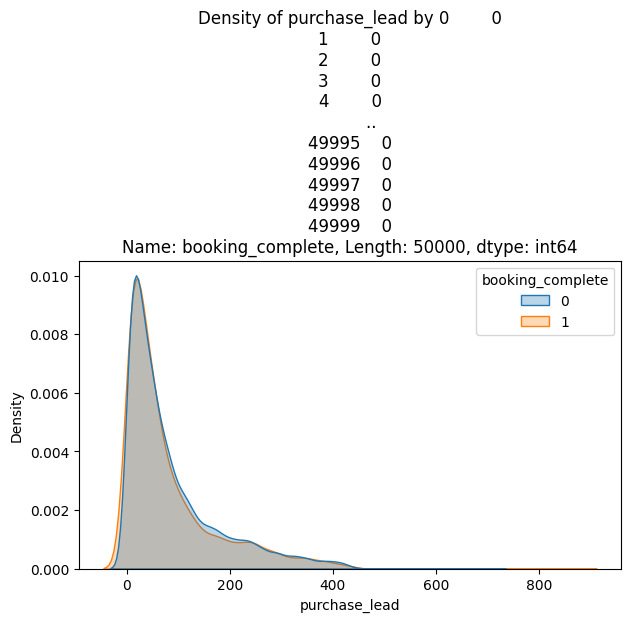

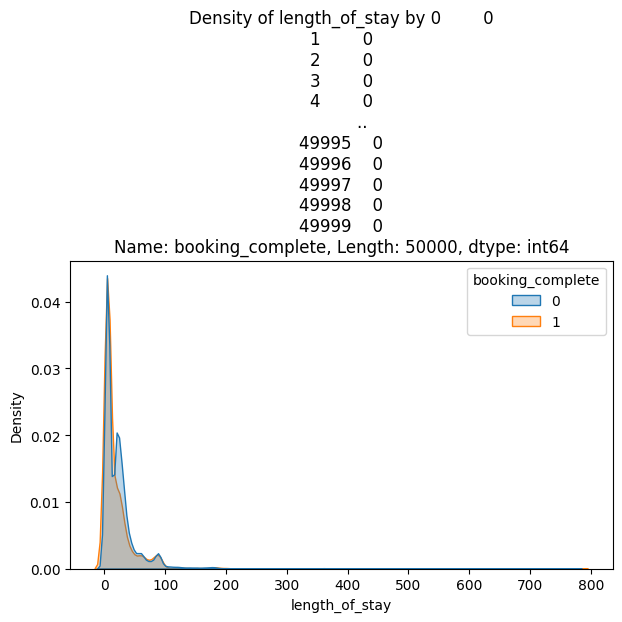

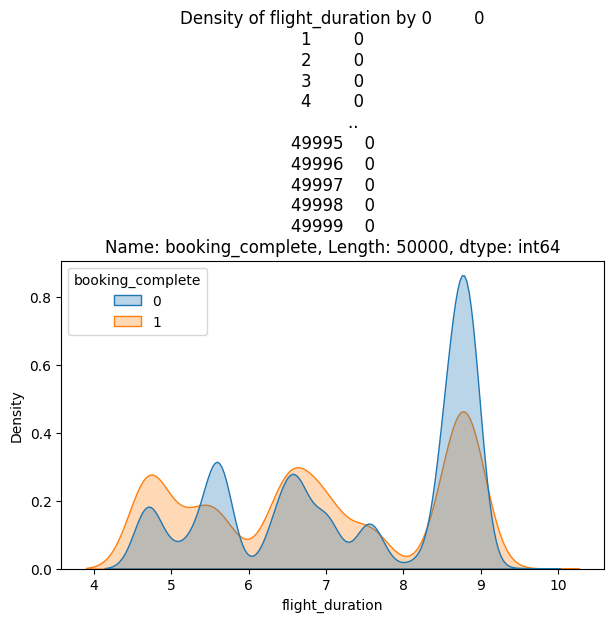

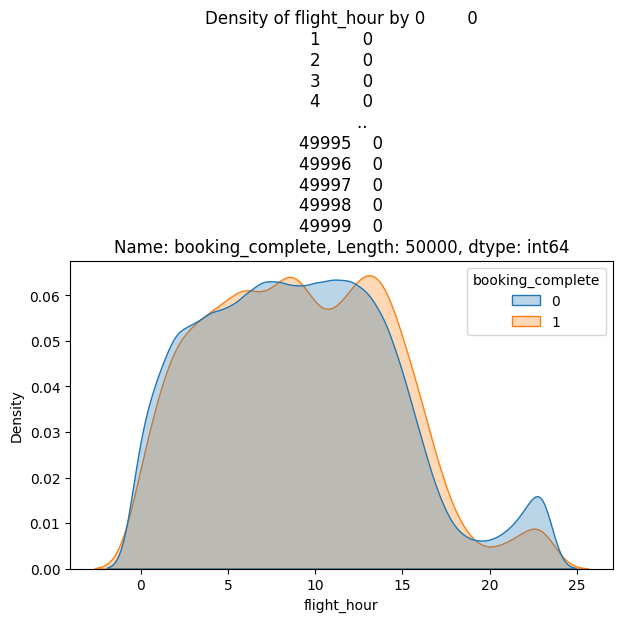

In [19]:
for col in cols_target:
    plt.figure(figsize=(7,4))
    sns.kdeplot(data=df, x=col, hue=target, common_norm=False, fill=True, alpha=0.3)
    plt.title(f"Density of {col} by {target}")
    plt.xlabel(col)
    plt.show()


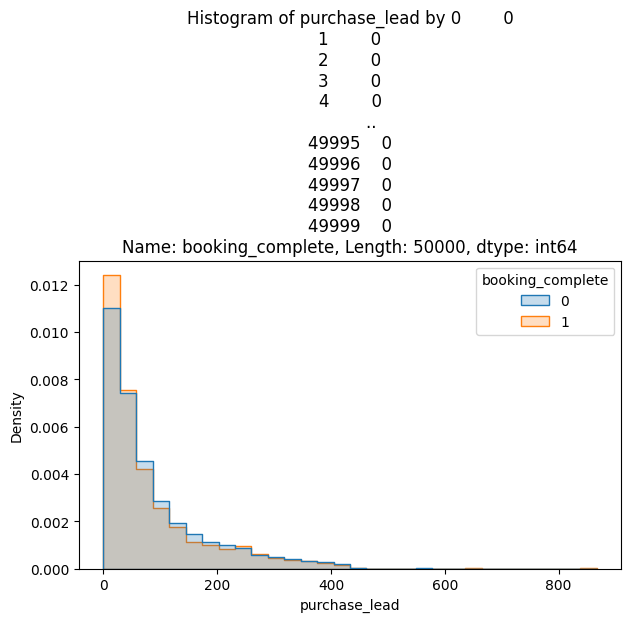

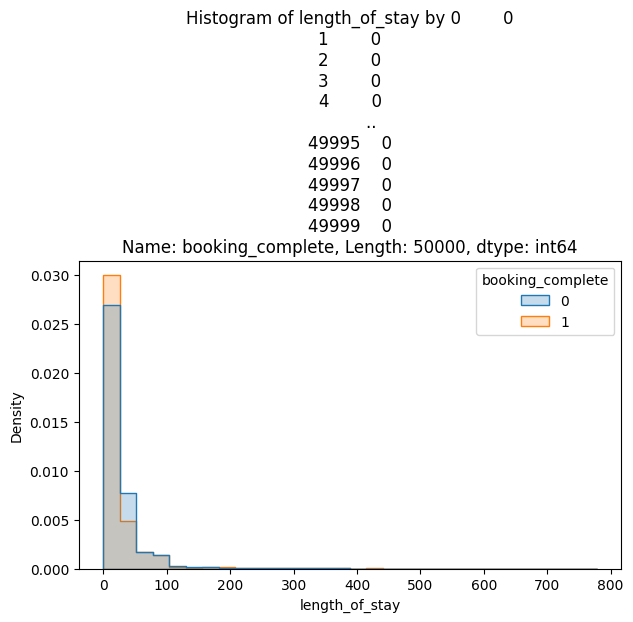

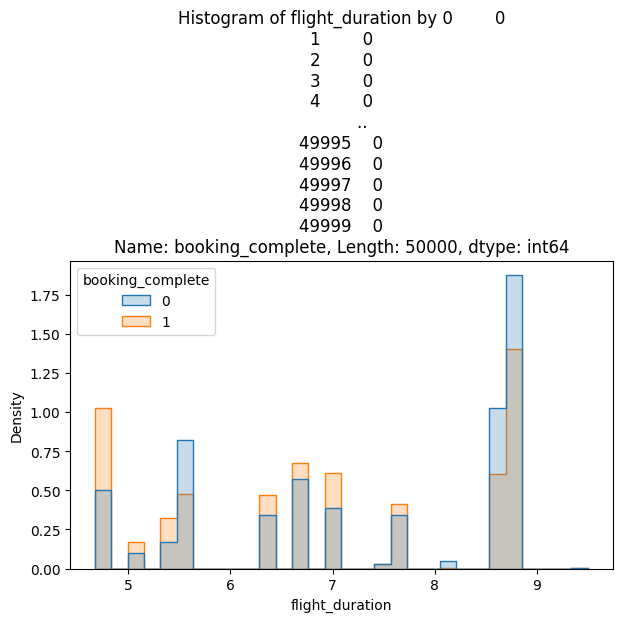

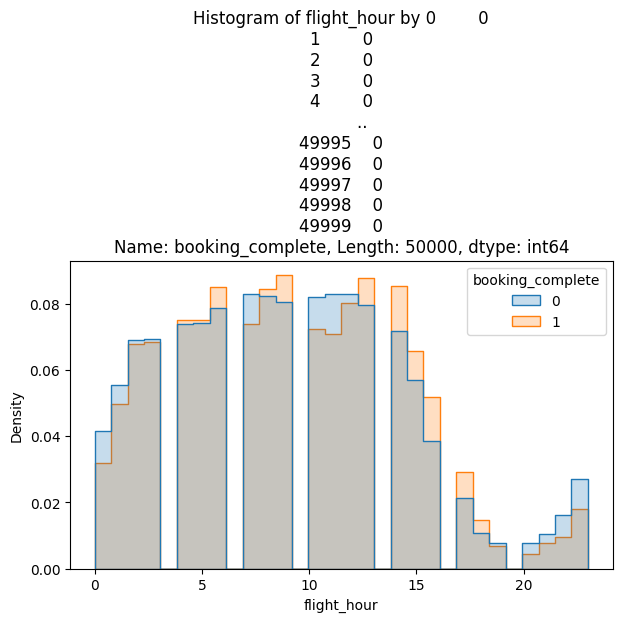

In [20]:
for col in cols_target:
    plt.figure(figsize=(7,4))
    sns.histplot(data=df, x=col, hue=target, element="step", stat="density", common_norm=False, bins=30)
    plt.title(f"Histogram of {col} by {target}")
    plt.xlabel(col)
    plt.show()


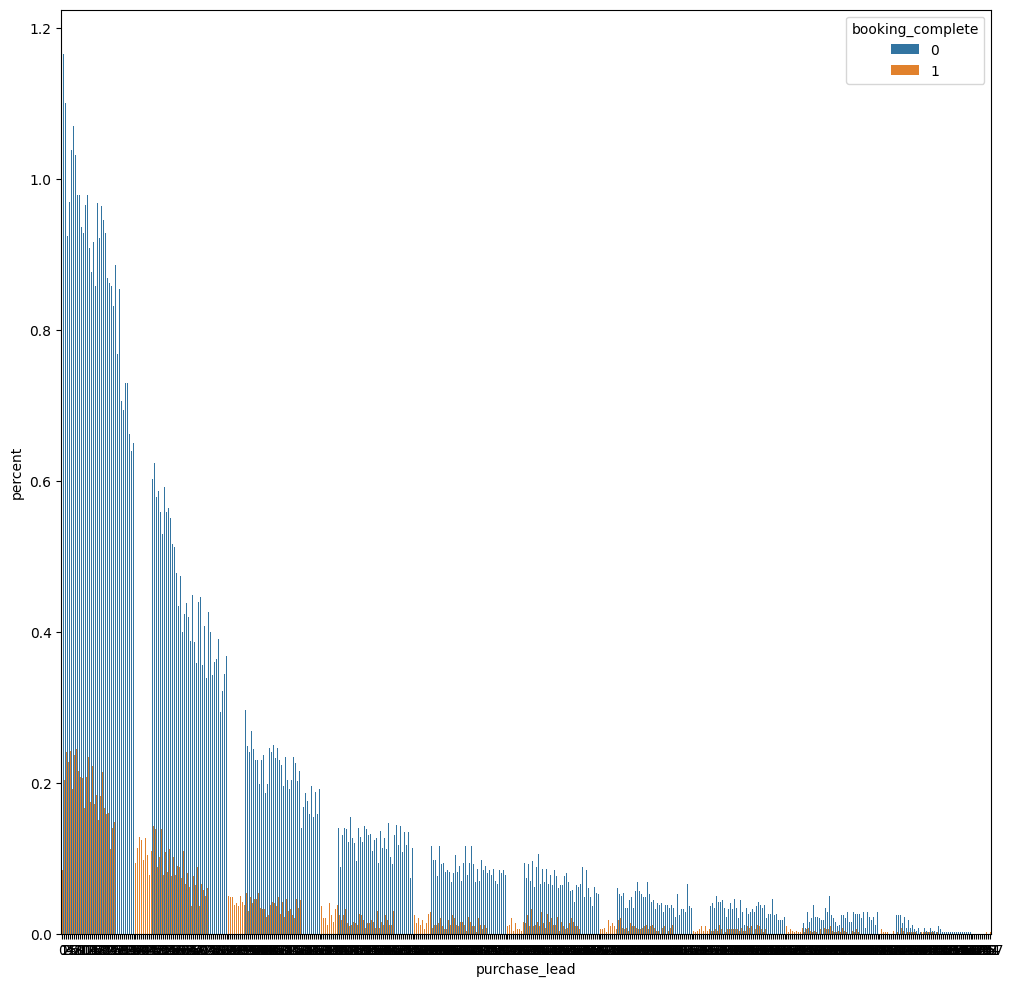

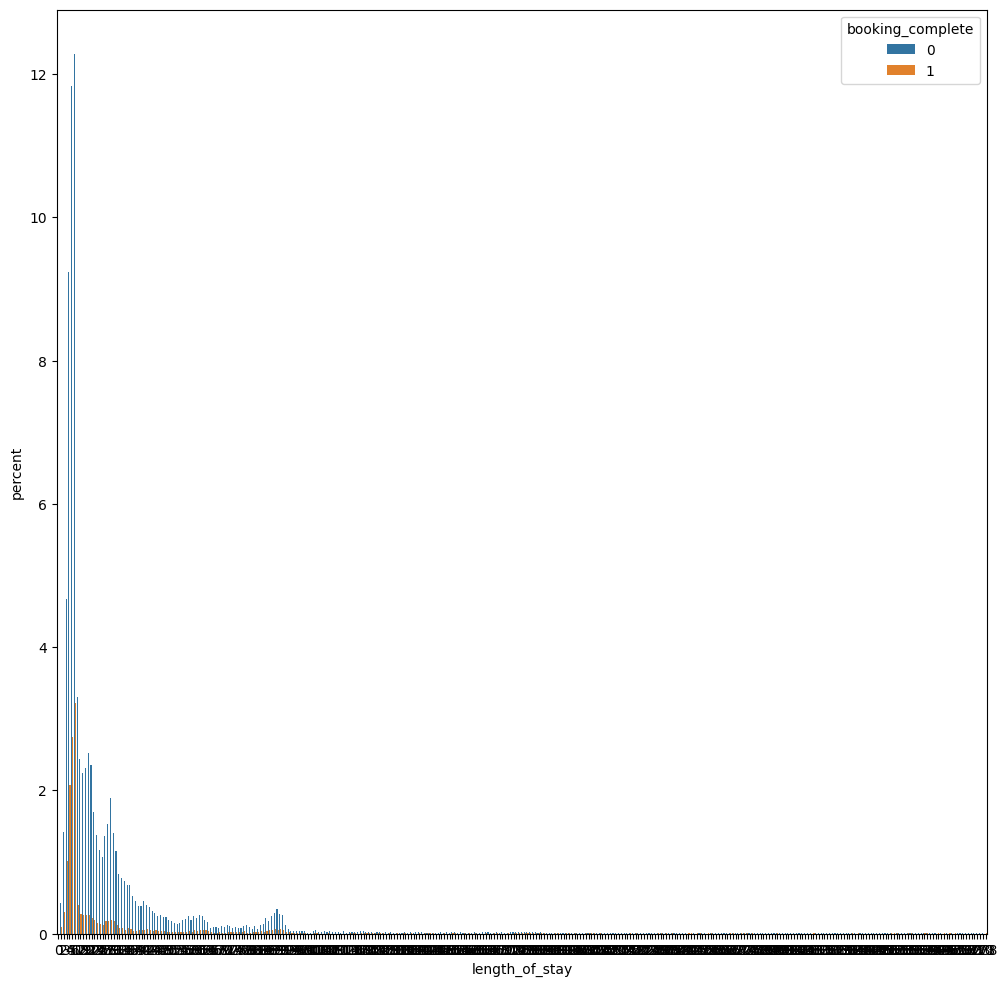

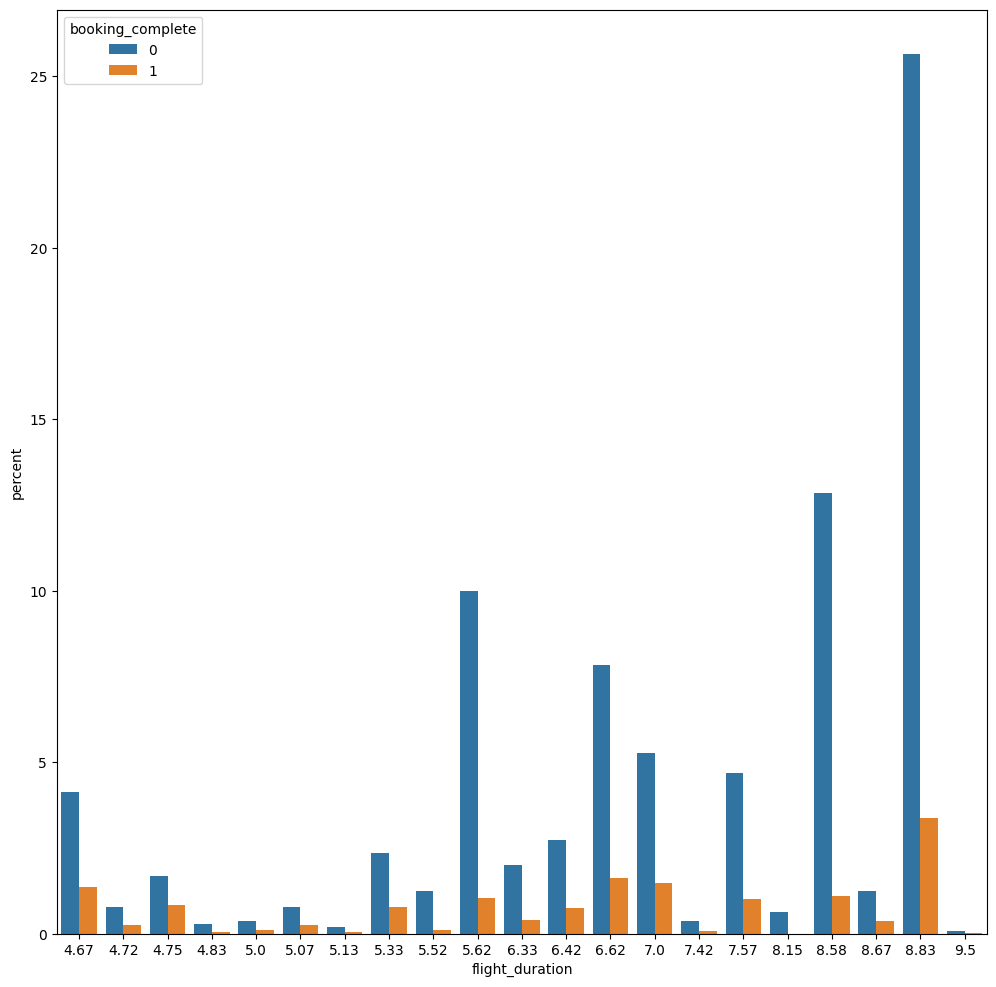

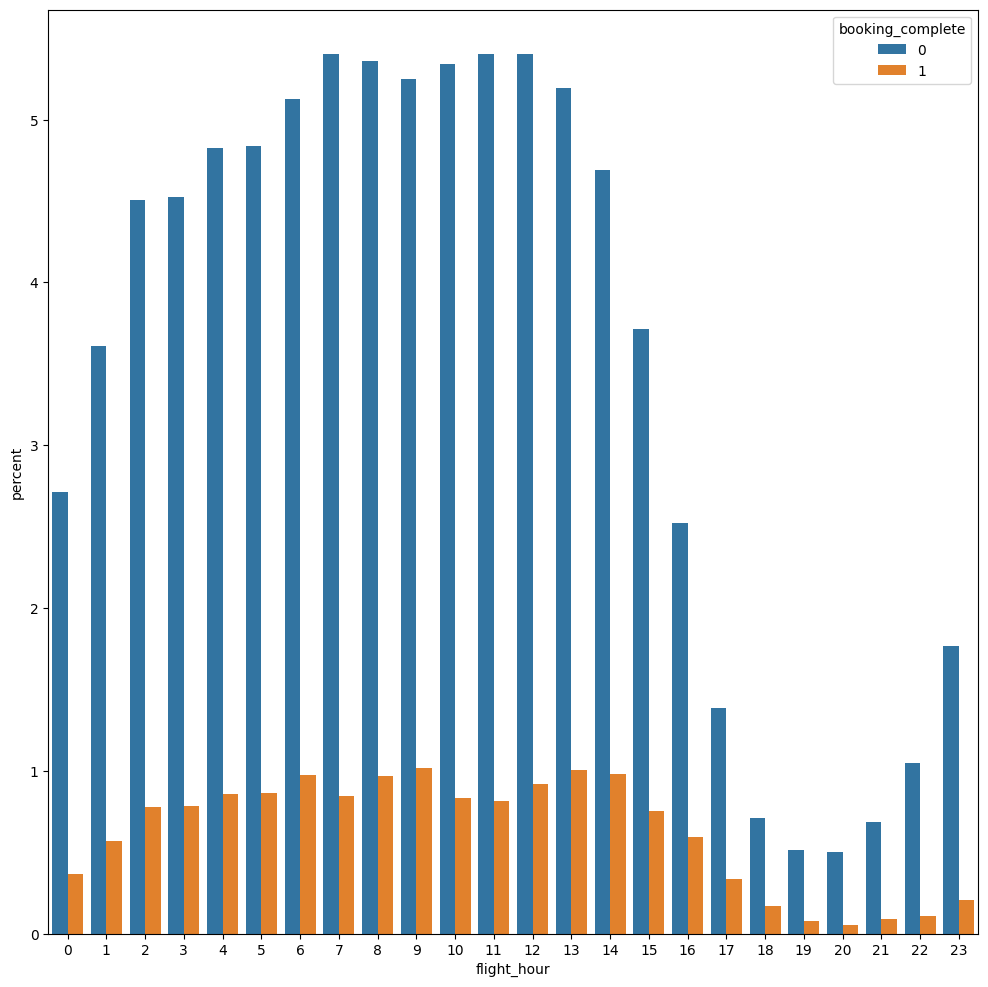

In [26]:
for cols in cols_target:
    plt.figure(figsize=(12,12))
    sns.countplot(data=df,x=cols,hue=target,stat="percent")
    plt.show()

In [21]:
def completion_rate(df, col, target='booking_complete'):
    out = (df.groupby(col)[target].mean().sort_values(ascending=False).rename('completion_rate').to_frame())
    out['count'] = df[col].value_counts().reindex(out.index)
    return (out*100).round(2)
binned_cols = [c for c in ['lead_bin','stay_bin'] if c in df.columns]
for col in binned_cols:
    rates = completion_rate(df, col, target=target)
    ax = rates['completion_rate'].plot(kind='bar', figsize=(7,4), color='#4C78A8')
    ax.set_title(f"Completion Rate by {col} (with counts)")
    ax.set_ylabel("Completion rate (%)")
    ax.set_xlabel(col)
    # Annotate counts
    for p, cnt in zip(ax.patches, rates['count'].values):
        ax.annotate(f"n={int(cnt)}", (p.get_x()+p.get_width()/2, p.get_height()), ha='center', va='bottom', fontsize=9, rotation=0)
    plt.show()


C:\Users\nikhi\AppData\Local\Temp\ipykernel_15788\21232555.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



KeyError: 'Columns not found: 0, 1'

## Top 5  EDA insights and  Hypothese